In [1]:
!pip install spektral   #dont mention version
!pip install Keras     #dont mention version
!pip install tensorflow  #dont mention version
from spektral.layers import GCNConv #previously it was GraphConv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

# import spektral
# from spektral.layers import GatedGraphConv

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
# /content/drive/MyDrive/Colab Notebooks/Project 2/cora.tgz
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/MyDrive/Colab Notebooks/Project 2/'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Project 2


In [4]:

all_data = []
all_edges = []


for root,dirs,files in os.walk('./cora'):
  for file in files:

    # we can see the data feature stored in cora.content
    if '.content' in file:
      with open(os.path.join(root,file),'r') as f:
        all_data.extend(f.read().splitlines())

    # we can see the edges are stored in cora.cites
    elif 'cites' in file:
        with open(os.path.join(root,file),'r') as f:
            all_edges.extend(f.read().splitlines())

                

all_data = shuffle(all_data,random_state=42)
# all_data

In [5]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
  # gain data from a matrix into list
  elements = data.split('\t')

  # classes are the last column entries
  labels.append(elements[-1])

  X.append(elements[1:-1])

  # nodes are the first column entries
  nodes.append(elements[0])

X = np.array(X,dtype=int)

# nodes denoted by N is the rows of X
N = X.shape[0] 

# features denoted by F is the columns of X
F = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
  e = edge.split('\t')
  edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nNumber of edges (e):', len(edge_list))
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Number of edges (e): 5429

Categories:  {'Case_Based', 'Genetic_Algorithms', 'Theory', 'Rule_Learning', 'Reinforcement_Learning', 'Neural_Networks', 'Probabilistic_Methods'}

Number of classes:  7


In [6]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [29]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
# test_mask[test_idx] = True
test_mask[:] = True
print(test_mask.shape)

(2708,)


In [8]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [10]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)

In [12]:
# Set hyperparameters
num_output_channels = 16
dropout_rate = 0.5
l2_regularization = 5e-4
learning_rate = 1e-2
num_epochs = 200
early_stopping_patience = 10

# Preprocess data
# Add self-loops to the adjacency matrix and normalize it for the graph convolutional layer
adj_matrix = GCNConv.preprocess(A).astype('f4')

# Define model inputs
node_features = Input(shape=(F, ))
adjacency_matrix = Input((N, ), sparse=True)

# Define model architecture
# The model consists of two graph convolutional layers with dropout, followed by a softmax activation for classification
dropout1 = Dropout(dropout_rate)(node_features)
graph_conv1 = GCNConv(num_output_channels,
                      activation='relu',
                      kernel_regularizer=l2(l2_regularization),
                      use_bias=False)([dropout1, adjacency_matrix])
dropout2 = Dropout(dropout_rate)(graph_conv1)
graph_conv2 = GCNConv(num_classes,
                      activation='softmax',
                      use_bias=False)([dropout2, adjacency_matrix])

# Define and compile the model
# The Adam optimizer is used with the specified learning rate, and categorical cross-entropy is used as the loss function.
# The accuracy metric is also tracked during training.
model = Model(inputs=[node_features, adjacency_matrix], outputs=graph_conv2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])

# Print model summary
# The model architecture and number of parameters are printed to the console.
model.summary()

# Define callbacks
# A TensorBoard callback is defined to visualize the training process.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./Tensorboard_GCN_cora')
callbacks = [tensorboard_callback]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 16)           22928       ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

In [13]:

# Prepare validation data
# The validation data consists of the node features, adjacency matrix, one-hot encoded labels, and validation mask.
# The validation mask is a binary vector indicating which nodes belong to the validation set.

# Train model
# The model is trained using the fit() method with the node features, adjacency matrix, one-hot encoded labels, and training mask as input.
# The training mask is a binary vector indicating which nodes belong to the training set.
# Early stopping is used to prevent overfitting, and the TensorBoard callback is used to visualize the training process.

# Train the model
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=num_epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=callbacks)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.1172 - acc: 0.1071 - val_loss: 0.3760 - val_acc: 0.0680
Epoch 2/200
1/1 [==============================] - 0s 336ms/step - loss: 0.1159 - acc: 0.1071 - val_loss: 0.3747 - val_acc: 0.0840
Epoch 3/200
1/1 [==============================] - 0s 318ms/step - loss: 0.1151 - acc: 0.1143 - val_loss: 0.3734 - val_acc: 0.0940
Epoch 4/200
1/1 [==============================] - 0s 329ms/step - loss: 0.1146 - acc: 0.1714 - val_loss: 0.3722 - val_acc: 0.1060
Epoch 5/200
1/1 [==============================] - 0s 329ms/step - loss: 0.1139 - acc: 0.1286 - val_loss: 0.3709 - val_acc: 0.1160
Epoch 6/200
1/1 [==============================] - 0s 277ms/step - loss: 0.1127 - acc: 0.1786 - val_loss: 0.3697 - val_acc: 0.1240
Epoch 7/200
1/1 [==============================] - 0s 178ms/step - loss: 0.1124 - acc: 0.1643 - val_loss: 0.3686 - val_acc: 0.1440
Epoch 8/200
1/1 [==============================] - 0s 180ms/step - loss: 0.1110 - acc:

In [30]:
# Select the node features, adjacency matrix, and ground truth labels corresponding to the test set
X_test = X[test_mask]
A_test = A[test_mask, :][:, test_mask]
y_test = np.argmax(labels_encoded[test_mask], axis=1)

# Predict the class probabilities for the test set nodes using the trained GCN model
y_pred = model.predict([X_test, A_test], batch_size=N)

# Convert the predicted class probabilities into class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute and print the classification report
report = classification_report(y_test, y_pred_labels, target_names=classes)
print('GCN Classification Report:\n{}'.format(report))

(2708, 1433) (2708, 2708)
1/1 [==============================] - 0s 110ms/step
GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.73      0.84      0.78       298
    Genetic_Algorithms       0.92      0.93      0.92       418
       Neural_Networks       0.94      0.71      0.81       818
 Probabilistic_Methods       0.78      0.87      0.82       426
Reinforcement_Learning       0.72      0.90      0.80       217
         Rule_Learning       0.72      0.89      0.80       180
                Theory       0.71      0.72      0.71       351

              accuracy                           0.81      2708
             macro avg       0.79      0.84      0.81      2708
          weighted avg       0.83      0.81      0.81      2708



In [15]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

1/1 [==============================] - 0s 160ms/step


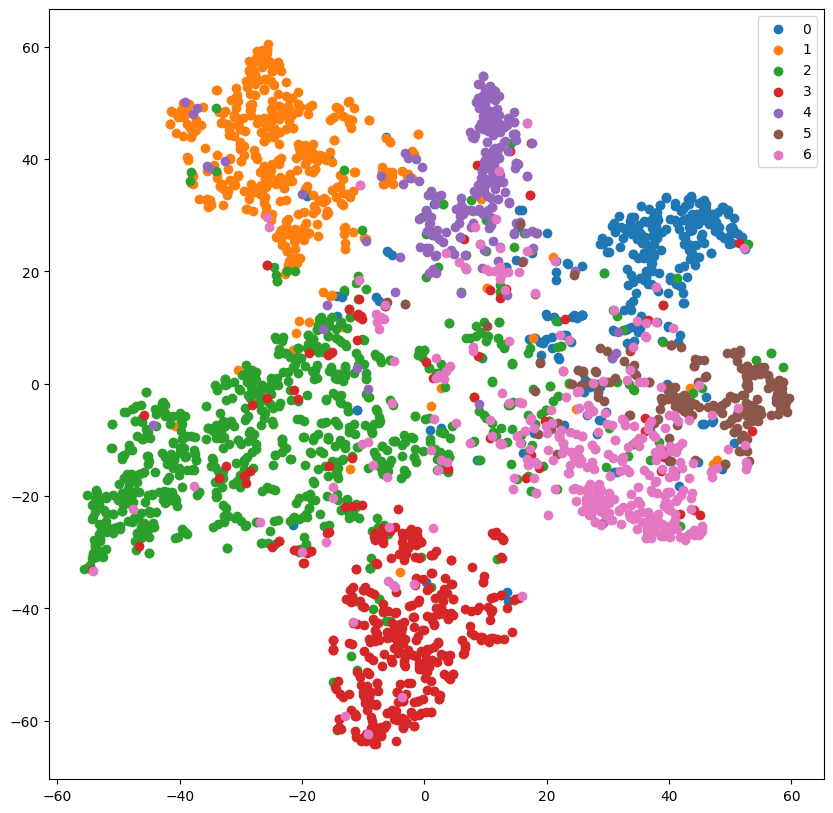

In [16]:
def plot_tSNE(labels_encoded, x_tsne):
    # Create a new figure with size 10x10 inches
    fig, ax = plt.subplots(figsize=(10,10))
    
    # Get the label index with the highest value for each node
    color_map = np.argmax(labels_encoded, axis=1)
    
    # Get the unique classes in the color_map array
    classes = np.unique(color_map)
    
    # Define a color map for each class
    cmap = plt.get_cmap('tab10', len(classes))
    
    # Iterate over the unique classes and plot the t-SNE embeddings for each class
    for i, cl in enumerate(classes):
        # Find the indices of the nodes that belong to the current class
        indices = np.where(color_map == cl)[0]
        
        # Plot the t-SNE embeddings for the current class with a unique color
        ax.scatter(x_tsne[indices,0], x_tsne[indices,1], label=cl, c=cmap(i), alpha=0.7)
    
    # Add a legend to the plot and show it
    ax.legend()
    plt.show()

    
plot_tSNE(labels_encoded,x_tsne)